<a href="https://colab.research.google.com/github/garv26/Twitter-emotion-Detection/blob/main/tweet_emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt # plotting
import tensorflow as tf
from keras.layers import Dropout, Dense, GRU, Embedding, LSTM, Bidirectional, TimeDistributed, Flatten
from tensorflow.keras.models import Sequential
import random

In [ ]:
import pandas as pd

data = pd.read_pickle("merged_training.pkl")

In [ ]:
data.head(5)

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


<Axes: >

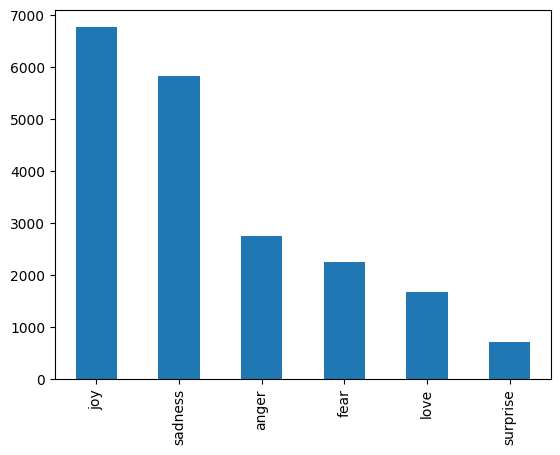

In [ ]:
#data= data[data["emotions"].isin(emotions)]


data = data.sample(n=20000);

data.emotions.value_counts().plot.bar()

In [ ]:
data.count()

text        20000
emotions    20000
dtype: int64

In [ ]:
## reset index
data.reset_index(drop=True, inplace=True)

In [ ]:
data.head()

,text,emotions
0,i dont know why i feel so unimportant,sadness
1,i think back on this moment i always feel amaz...,surprise
2,i feel so useless so pathetic,sadness
3,i feel so bless to have my parents my siblings...,love
4,i feel so assured that i am still the same per...,joy


In [ ]:
## check unique emotions in the dataset
data.emotions.unique()

array(['sadness', 'surprise', 'love', 'joy', 'anger', 'fear'],
      dtype=object)

In [ ]:
train_path = "train.csv"
test_path = "test.csv"
val_path = "val.csv"

In [ ]:


from sklearn.model_selection import train_test_split
import numpy as np

# Creating training and validation sets using an 80-20 split
input_train, input_val, target_train, target_val = train_test_split(data.text,
                                                                    data.emotions,
                                                                    test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.5)


## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "emotions": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "emotions": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "emotions": target_test})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

train_dataset.to_csv(train_path, sep=";",header=False, index=False)
val_dataset.to_csv(test_path, sep=";",header=False, index=False)
test_dataset.to_csv(val_path, sep=";",header=False, index=False)


In [ ]:
from google.colab import files
files.download('train.csv')
files.download('test.csv')
files.download('val.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train=final_dataset['train']
test=final_dataset['test']
val=final_dataset['val']

In [ ]:
train.head()

,text,emotions
7867,im feeling very insulted right now,anger
16761,im so proud of trying more and participating m...,joy
13271,i remember how my freshman year of high school...,surprise
5917,i am feeling thankful and wanted to share,joy
10364,i thought how i feel that with jason and thats...,love


In [ ]:
train.reset_index(drop=True, inplace=True)

In [ ]:
tweets=train.text
label=train.emotions

In [ ]:
tweets[0:5]

0                   im feeling very insulted right now
1    im so proud of trying more and participating m...
2    i remember how my freshman year of high school...
3            i am feeling thankful and wanted to share
4    i thought how i feel that with jason and thats...
Name: text, dtype: object

In [ ]:
tweets[4],label[4]

('i thought how i feel that with jason and thats a main reason i stay with him no matter what if hes trying to live and faithful',
 'love')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer=Tokenizer(num_words=1000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences(tweets[0])

[[2],
 [85],
 [],
 [1],
 [1],
 [1],
 [1],
 [2],
 [1],
 [1],
 [],
 [1],
 [1],
 [1],
 [1],
 [],
 [2],
 [1],
 [84],
 [856],
 [1],
 [43],
 [1],
 [635],
 [],
 [1],
 [2],
 [1],
 [1],
 [43],
 [],
 [1],
 [1],
 [1]]

In [ ]:
tweets[4]

'i thought how i feel that with jason and thats a main reason i stay with him no matter what if hes trying to live and faithful'

## **Padding and Truncating Sequences**

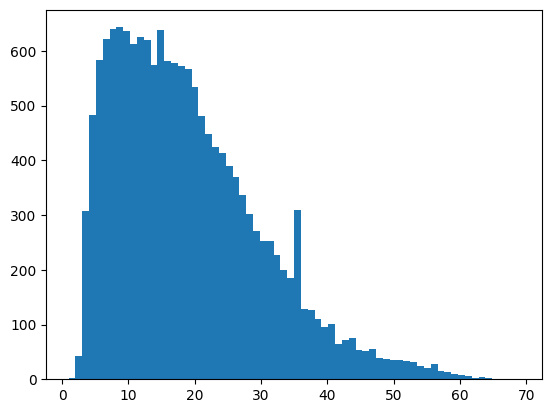

In [ ]:
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [ ]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,truncating='post',padding="post",maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq=get_sequences(tokenizer,tweets)

In [ ]:
padded_train_seq[0]

array([ 17,   8,  46, 604, 111,  59,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

### **Preparing the Labels**

In [ ]:
classes=set(label)
print(classes)

{'anger', 'surprise', 'sadness', 'fear', 'love', 'joy'}


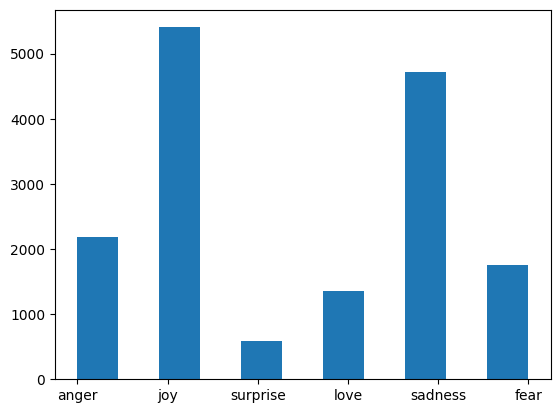

In [ ]:
plt.hist(label,bins=11)
plt.show()

In [ ]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in class_to_index.items())

In [ ]:
class_to_index

{'anger': 0, 'surprise': 1, 'sadness': 2, 'fear': 3, 'love': 4, 'joy': 5}

In [ ]:
index_to_class

{0: 'anger', 1: 'surprise', 2: 'sadness', 3: 'fear', 4: 'love', 5: 'joy'}

In [ ]:
names_to_ids=lambda label:np.array([class_to_index.get(x) for x in label])

In [ ]:
train_label=names_to_ids(label)
print(train_label[5])

5


## **Creating the Model**

In [ ]:
model=tf.keras.models.Sequential(
    [
        tf.keras.layers.Embedding(1000,16,input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6,activation='softmax')
    ]
)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            16000     
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 31,926
Trainable params: 31,926
Non-trainable params: 0
_________________________________________________________________


## **Training the Model**

In [ ]:
val.reset_index(drop=True, inplace=True)

In [ ]:
val_tweets=val.text
val_label=val.emotions

In [ ]:
val_seq=get_sequences(tokenizer,val_tweets)
val_label=names_to_ids(val_label)

In [ ]:
val_tweets[0]

'i can t really seem to sleep today i feel uncertain of the future'

In [ ]:
h=model.fit(
    padded_train_seq,train_label,
    validation_data=(val_seq,val_label),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 42s 70ms/step - loss: 1.3621 - accuracy: 0.4421 - val_loss: 0.8728 - val_accuracy: 0.6660
Epoch 2/20
500/500 [==============================] - 40s 81ms/step - loss: 0.6389 - accuracy: 0.7699 - val_loss: 0.5584 - val_accuracy: 0.8175
Epoch 3/20
500/500 [==============================] - 32s 64ms/step - loss: 0.4560 - accuracy: 0.8451 - val_loss: 0.5915 - val_accuracy: 0.7995
Epoch 4/20
500/500 [==============================] - 33s 65ms/step - loss: 0.3960 - accuracy: 0.8622 - val_loss: 0.4709 - val_accuracy: 0.8255
Epoch 5/20
500/500 [==============================] - 31s 62ms/step - loss: 0.3532 - accuracy: 0.8716 - val_loss: 0.4597 - val_accuracy: 0.8320
Epoch 6/20
500/500 [==============================] - 33s 66ms/step - loss: 0.3355 - accuracy: 0.8776 - val_loss: 0.4802 - val_accuracy: 0.8300
Epoch 7/20
500/500 [==============================] - 34s 68ms/step - loss: 0.3193 - accuracy: 0.8828 - val_loss: 0.4616 - val_accuracy:

## **Evaluating the Model**

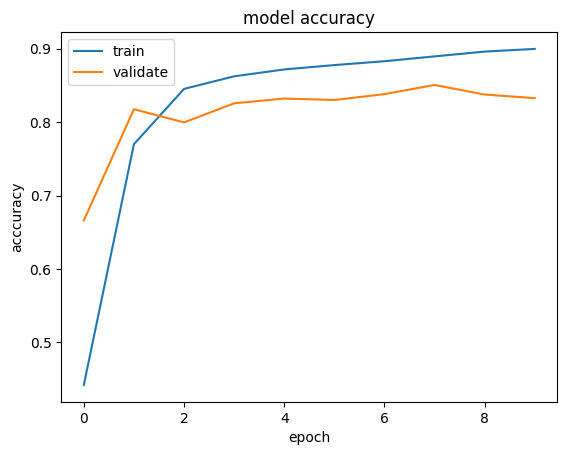

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acccuracy')
plt.xlabel('epoch')
#plt.ylim(0.8,0.94)
plt.legend(['train', 'validate'], loc = 'upper left')
plt.show()

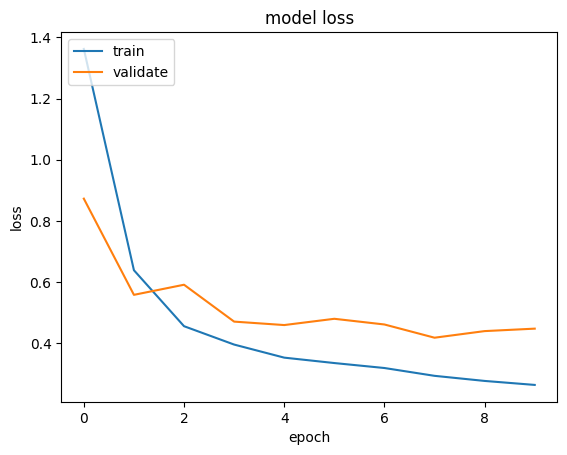

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc = 'upper left')
plt.show()

## **Testing the model**

In [ ]:
test.reset_index(drop=True, inplace=True)

In [ ]:
test_tweets=test.text
test_label=test.emotions
test_seq=get_sequences(tokenizer,test_tweets)
test_label=names_to_ids(test_label)

In [ ]:
t=model.evaluate(test_seq,test_label)

63/63 [==============================] - 1s 17ms/step - loss: 0.3708 - accuracy: 0.8635


In [ ]:
i=random.randint(0,len(test_label)-1)
print('sentence:',test_tweets[i])
print('Emotion',index_to_class[test_label[i]])
p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')]
print('Predicted emotion:',pred_class)

sentence: i feel really lame fore possibly ranting on tumblr
Emotion sadness
1/1 [==============================] - 0s 32ms/step
Predicted emotion: sadness


## **Saving the model**

In [ ]:
!pip install h5py

In [ ]:
model.save('tweet_emotion_prediction.h5')

In [ ]:
import pickle

In [ ]:
filename='tweet_prediction.sav'
pickle.dump(model, open(filename, 'wb'))

## **Loading the model**

In [ ]:
loaded_model=pickle.load(open('tweet_prediction.sav', 'rb'))

In [ ]:
i=random.randint(0,len(test_label)-1)
print('sentence:',test_tweets[i])
print('Emotion',index_to_class[test_label[i]])
p=loaded_model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')]
print('Predicted emotion:',pred_class)

sentence: i have discovered certain ways to keep myself feeling good
Emotion joy
1/1 [==============================] - 2s 2s/step
Predicted emotion: joy
